In [1]:
import os
os.chdir("/app/")

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from math import log
from ptls.data_load.utils import collate_feature_dict
from torchmetrics.functional import auroc

from src.generation.modules import VanillaAE
from src.preprocessing import preprocess
from src.generation.datasets import SimpleTRXDataset
import torch
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, r2_score, mean_squared_error
from scipy.special import softmax
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from omegaconf import OmegaConf

In [3]:
train, val, test = preprocess(OmegaConf.load("config/preprocessing/churn_ae.yaml")) # type: ignore

________________________________________________________________________________
[Memory] Calling src.preprocessing.preprocess.preprocess.<locals>._preprocess...
_preprocess({ 'cache_dir': 'cache',
  'random_state': 42,
  'source': 'data/preprocessed_new/churn.parquet',
  'test_size': 0.1,
  'transforms': [ { '_target_': 'src.preprocessing.ToType',
                    'col_name_original': 'amount',
                    'target_type': 'float32'},
                  { '_target_': 'src.preprocessing.DropQuantile',
                    'col_name_original': 'amount',
                    'q_max': 0.95,
                    'q_min': 0.05},
                  { '_target_': 'src.preprocessing.DropRare',
                    'col_name_original': 'mcc_code',
                    'k': 100},
                  { '_target_': 'ptls.preprocessing.PandasDataPreprocessor',
                    'col_event_time': 'timestamp',
                    'col_id': 'user_id',
                    'cols_category': [...],
    

In [4]:
ds = SimpleTRXDataset(val, 40, 32, 32, False)
dl = DataLoader(ds, shuffle=False, collate_fn=collate_feature_dict, batch_size=256)

In [5]:
model = VanillaAE.load_from_checkpoint("macro_micro_coles/xj2hlnjb/checkpoints/epoch=476-step=6201.ckpt")

In [6]:
trainer = Trainer(False, accelerator="gpu", devices=1)

/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
amt_pred = torch.cat([torch.stack(b[1]) for b in trainer.predict(model, dl)]) # (n_batches, batch_size, length)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [8]:
amt_true = torch.stack([row["amount"] for row in ds])

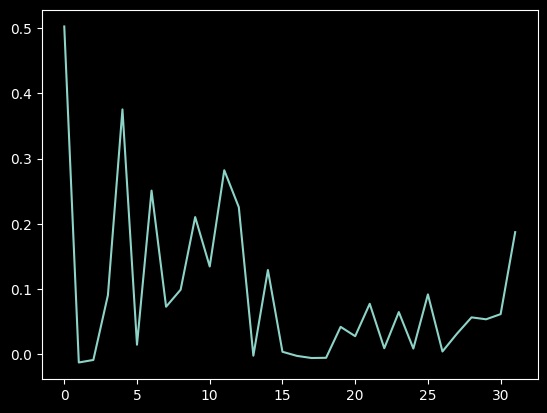

In [9]:
r2_by_token_num = [r2_score(true.flatten(), pred.flatten()) for true, pred in zip(amt_true.T, amt_pred.T)]
plt.plot(r2_by_token_num)

In [10]:
argsort = torch.argsort(amt_true.flatten())

amt_true_sorted = amt_true.flatten()[argsort]
amt_pred_sorted = amt_pred.flatten()[argsort]

amt_sorted = torch.stack([amt_true_sorted, amt_pred_sorted])

In [11]:
bsize = 10000

true_bin = amt_true_sorted[:bsize]
pred_bin = amt_pred_sorted[:bsize]

RSS = ((true_bin - pred_bin) ** 2).mean()
TSS = ((true_bin - true_bin.mean()) ** 2).mean()

print(f"{RSS=}")
print(f"{TSS=}")

RSS=tensor(7271049.5000)
TSS=tensor(3320457.7500)


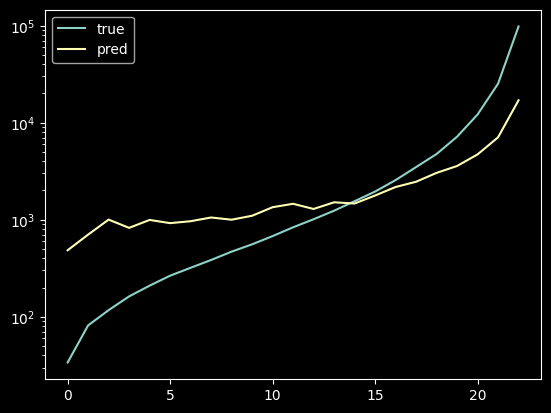

In [12]:
fig, ax = plt.subplots()

ax.plot([b.mean() for b in amt_true_sorted.split(500)], label="true")
ax.plot([b.mean() for b in amt_pred_sorted.split(500)], label="pred")
ax.set_yscale("log")
ax.legend()

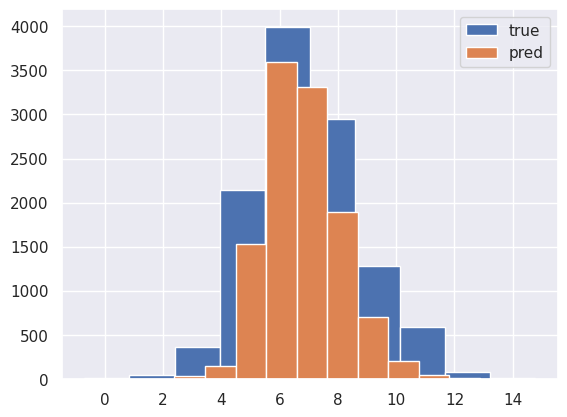

In [14]:
sns.set_theme()

ax, fig = plt.subplots()
fig.hist(amt_true_sorted.log(), label="true")
fig.hist(amt_pred_sorted.log(), label="pred")

plt.legend()

In [16]:
r2_score(amt_true_sorted, amt_pred_sorted)

0.032192422471743476

In [17]:
r2_binned = [r2_score(torch.log(true), torch.log(pred)) for true, pred in amt_sorted.split(500, 1)]

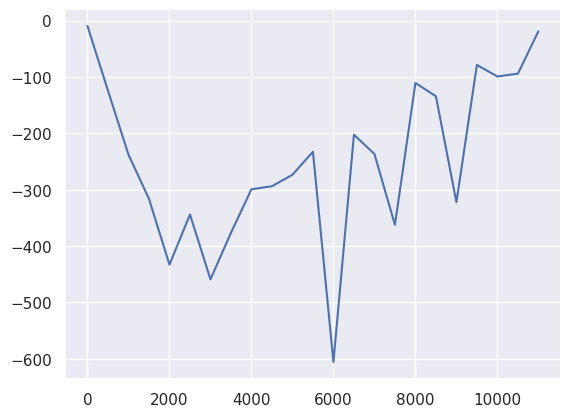

In [18]:
plt.plot(torch.arange(0, amt_sorted.shape[1], 500), r2_binned)

In [19]:
mse_binned = [log(mean_squared_error(true, pred)) for true, pred in amt_sorted.split(1000, 1)]

ValueError: x and y must have same first dimension, but have shapes torch.Size([23]) and (12,)

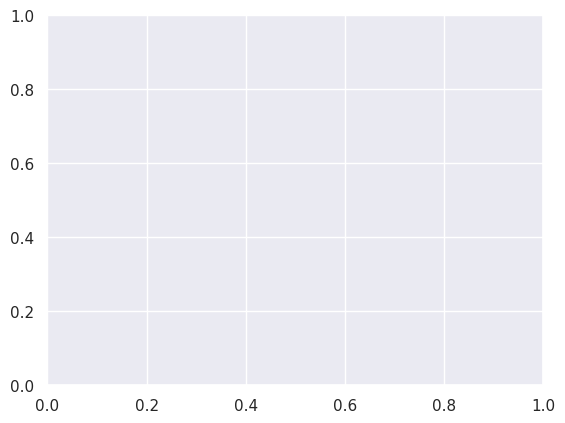

In [20]:
plt.plot(torch.arange(0, amt_sorted.shape[1], 500), mse_binned)